Import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [ ]:
# Added to be able to run in Google Colab. Run this cell if running the notebook in a hosted runtime. Don't run for a local runtime.

from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')    # Set this to the directory where you have saved the "utils" directory of Python scripts.
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')       # Set this to the directory where you have saved the "utils" directory of Python scripts.

import utils

In [ ]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from skimage.filters import threshold_otsu

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
1.13.1+cu116


In [ ]:
# Check the specifications of your machine/what resources you have been allocated through Colab.

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 18 18:39:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [ ]:
# Here define the path, which is used to save the log and trained model in training process

project_name = '01_Generalized_Model_FullTrainingData'
trial = 'Trial_03' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 50
weight_reg = 2.0    # Balances regression loss with segmentation loss. Value chosen based on past investigation.
weight_background = 0.1   # For regression loss only, downweights background pixels to highlight foreground pollen

#model parameters
batch_size = 4
newSize = [800,800]       # set to crop size, to tell model what size tensor to expect
total_epoch_num = 30      # total number of epoch in training
base_lr =0.0005           # base learning rate
scaleList = [0]           # the number of output layer for U-net

exp_dir = '/content/gdrive/MyDrive/exp' 
exp_dir = os.path.join(exp_dir, project_name)
save_dir = os.path.join(exp_dir, trial) # Location to save log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

cuda:0


In [ ]:
path_to_image = '/content/gdrive/Othercomputers/My MacBook Air/Training_Tiles3'
path_to_annotCombo = '/content/gdrive/MyDrive/UTRECHT/Detection/AnnotCombo9_noNPP_circleMask'
with open(os.path.join(save_dir,'dbinfo.pkl'), 'rb') as handle:
    dbinfo = pickle.load(handle)    
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list']), 2389, 597)

In [ ]:
class PollenDet(Dataset):
    def __init__(self, path_to_image='/content/gdrive/MyDrive/UTRECHT/Detection/Training_Tiles3',
                 path_to_annot='/content/gdrive/MyDrive/UTRECHT/Detection/AnnotCombo9_noNPP_circleMask',
                 path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/Masks9_noNPP_circleMask',
                 dbinfo=dbinfo,
                 size=[1040,1392], 
                 set_name='train'):
        
        self.path_to_image = path_to_image
        self.path_to_annot = path_to_annot
        self.path_to_mask = path_to_mask
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        self.resizeFactor = size[0]/1000
        
        self.sampleList = self.dbinfo[set_name+'_det_list']

        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))

        
        self.TFRandomCrop = transforms.RandomCrop(800)
        self.TFHFlip = transforms.RandomHorizontalFlip()

    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        current_example= self.sampleList[idx]

        current_image_path= os.path.join(self.path_to_image, current_example)
        current_distTransform_path=os.path.join(self.path_to_mask, current_example)
        curPickleName = os.path.join(self.path_to_annot, current_example)

        imagestack_array = []
        for file in sorted(os.listdir(current_image_path)):
          if file.endswith('.bmp'):
            slice = Image.open(os.path.join(current_image_path, file))
            imagestack_array.append(np.asarray(slice))
            image = np.block(imagestack_array)
          if image.shape[2] <27:
            pad_val = 27-image.shape[2]
            npad = ((0, 0), (0,0), (0,pad_val))
            image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

        for file in os.listdir(current_distTransform_path):
          if file.endswith('.bmp'):
            mask = Image.open(os.path.join(current_distTransform_path, file))
            mask=np.array(mask)

        for file in os.listdir(curPickleName):
          if file.endswith('.pkl'):
            with open(os.path.join(curPickleName, file), 'rb') as handle:
              annot = pickle.load(handle)

        times = np.random.randint(1)       #### What is this section?
        if times!=0:
            if times==1:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[1]-x
                    annot['coord_peaks'][i][1] = y
                    annot['size'] = (annot['size'][1], annot['size'][0])                    
            elif times==2:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[0]-y
                    annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[1]-x
            elif times==3:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = x
                    annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[0]-y
                    annot['size'] = (annot['size'][1], annot['size'][0])
            #for _ in range(times):
            image = np.rot90(image, times).copy()
        

        label = np.copy(mask)         # 11/30/21 added
        label[label > 0] = 1          # 11/30/21 added
        
        mask_distanceTransform = mask     #11/18/21 edited
        mask_peaks = label*0.
        mask_radius = label*0.
        mask_voteX = label*0.
        mask_voteY = label*0.
        mask_overlap = label*0.
        
        for i in range(annot['coord_peaks'].shape[0]):
            y, x = annot['coord_peaks'][i]
            r = annot['mask_radius'][i]
            mask_peaks[y-10:y+10, x-10:x+10] = 1
            mask_radius[y-10:y+10, x-10:x+10] = r

            mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
            mask_x, mask_y = np.meshgrid(mask_x, mask_y)
            mask_x = float(x) - mask_x
            mask_y = float(y) - mask_y

            tmpDistTransform = np.sqrt(mask_x*mask_x + mask_y*mask_y)
            tmpmask_vote = tmpDistTransform <= r
            # label[tmpmask_vote] = 1.0     #11/18/21 commented out
            mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
            mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
            # mask_distanceTransform[tmpmask_vote] = r-tmpDistTransform[tmpmask_vote]    #11/18/21 commented out
            mask_overlap += tmpmask_vote.astype(np.float)
            
        mask_overlap = mask_overlap>1
        mask_overlap = mask_overlap.astype(np.float32)/100.0/self.resizeFactor 
        # mask_overlap
        mask_voteX = mask_voteX.astype(np.float32)/100.0/self.resizeFactor 
        mask_voteY = mask_voteY.astype(np.float32)/100.0/self.resizeFactor 
        mask_distanceTransform = mask_distanceTransform.astype(np.float32)/100.0/self.resizeFactor  # factor=size[0]/1000
        mask_peaks = mask_peaks.astype(np.float32)/100.0/self.resizeFactor 
        mask_radius = mask_radius.astype(np.float32)/100.0/self.resizeFactor 
        
        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0) # self.TF2tensor(label)
        mask_overlap = torch.from_numpy(mask_overlap).unsqueeze(0) # self.TF2tensor(mask_overlap)
        mask_voteX = torch.from_numpy(mask_voteX).unsqueeze(0) # self.TF2tensor(mask_voteX)
        mask_voteY = torch.from_numpy(mask_voteY).unsqueeze(0) # self.TF2tensor(mask_voteY)
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) # self.TF2tensor(mask_distanceTransform)
        mask_peaks = torch.from_numpy(mask_peaks).unsqueeze(0) # self.TF2tensor(mask_peaks)
        mask_radius = torch.from_numpy(mask_radius).unsqueeze(0) # self.TF2tensor(mask_radius)

        image = image.unsqueeze(0)
        label = label.unsqueeze(0)        
        mask_distanceTransform = mask_distanceTransform.unsqueeze(0)
        mask_overlap = mask_overlap.unsqueeze(0)
        mask_voteX = mask_voteX.unsqueeze(0)
        mask_voteY = mask_voteY.unsqueeze(0)        
        mask_peaks = mask_peaks.unsqueeze(0)
        mask_radius = mask_radius.unsqueeze(0)        

        image_label = torch.cat([image, label,mask_distanceTransform,mask_overlap,mask_voteX,mask_voteY,mask_peaks, mask_radius], dim=1) #new 10/21/21 stack label with image for crop
        image_label = self.TFRandomCrop(image_label) #new 10/21/21
        image_label = self.TFHFlip(image_label)
        image = torch.narrow(image_label, 1, 0, image_label.shape[1]-7) #new 10/27/21  re-slice tensor into image and label
        label=torch.narrow(image_label, 1, image_label.shape[1]-7, 1) #new 10/27/21  re-slice tensor into image and label
        mask_distanceTransform=torch.narrow(image_label, 1, image_label.shape[1]-6, 1)
        mask_overlap=torch.narrow(image_label, 1, image_label.shape[1]-5, 1)
        mask_voteX=torch.narrow(image_label, 1, image_label.shape[1]-4, 1)
        mask_voteY=torch.narrow(image_label, 1, image_label.shape[1]-3, 1)
        mask_peaks=torch.narrow(image_label, 1, image_label.shape[1]-2, 1)
        mask_radius=torch.narrow(image_label, 1, image_label.shape[1]-1, 1)

        image = image.squeeze(0)
        label = label.squeeze(0)
        image_label = image_label.squeeze(0)
        mask_distanceTransform = mask_distanceTransform.squeeze(0)
        mask_overlap = mask_overlap.squeeze(0)
        mask_voteX = mask_voteX.squeeze(0)
        mask_voteY = mask_voteY.squeeze(0)
        mask_peaks = mask_peaks.squeeze(0)
        mask_radius = mask_radius.squeeze(0)
        image = self.TFNormalize(image)

        return image, label, mask_distanceTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius # current_example, idx

In [ ]:
det_datasets = {set_name: PollenDet(path_to_image=path_to_image,
                                    path_to_annot=path_to_annotCombo,
                                    dbinfo=dbinfo,
                                    size=newSize, 
                                    set_name=set_name)
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(det_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size. Increasing # workers may speed up data loading.
               for set_name in ['train', 'test']}

print(len(det_datasets['train']), len(det_datasets['test']))

2389 597


In [ ]:
data_sampler = iter(dataloaders['train'])
# print(sample)

In [ ]:
data = next(data_sampler)

In [ ]:
image=data[0]
label=data[1]
mask_distanceTransform=data[2]
mask_peaks=data[6]

Text(0.5, 1.0, 'image slice')

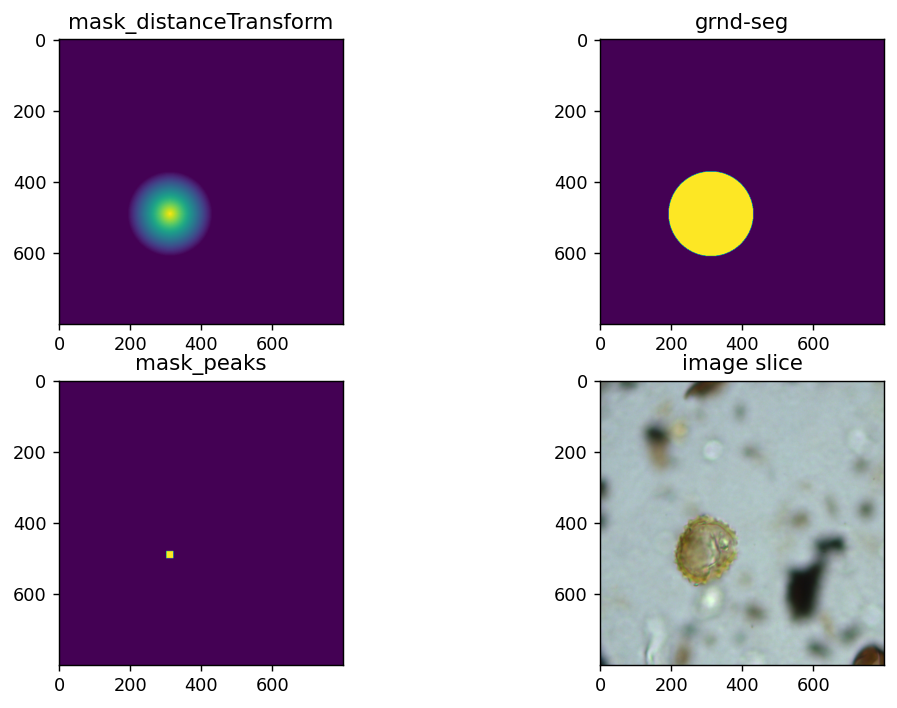

In [ ]:
idx = 0

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10, 10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_distanceTransform[idx].squeeze().cpu().detach().numpy()  #.transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('mask_distanceTransform')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = label[idx].squeeze().cpu().detach().numpy()  #.transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('grnd-seg')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_peaks[idx].squeeze().cpu().detach().numpy()  #.transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('mask_peaks')

i=[0,3,6,9,12,15,18,21,24]
j=[3,6,9,12,15,18,21,24,27]
idx2=3          # z-plane of the image stack to show
image_slice = image[:, int(i[idx2]):int(j[idx2]),: ,:]

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image_slice[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('image slice')


In [ ]:
################## init model ###################
initModel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
initModel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
initModel = initModel.to(device);

# # print(initModel.encoder.encoder)

In [ ]:
# loss for regression with masking
class MaskWeightedL1(nn.Module):
    def __init__(self, wBG=0.5, wFactor=1):
        super(MaskWeightedL1, self).__init__()        
        self.wBG = wBG
        self.wFactor = wFactor 
        
    def forward(self, inputs, target, segMask, overlapMask): 
        N, C, H, W = inputs.shape    #if mask only has 1 channel, C=1
        output = inputs - target
        totalNum = H * W * N
        output = torch.abs(output)
        output = torch.mean(output, 1, keepdim=True)
                
        output = output * (segMask + self.wBG) * (1-overlapMask)
        
        lossValue = output.sum() / totalNum
        return lossValue*self.wFactor

In [ ]:
# loss for (binary) segmentation
weight = torch.ones(2)
weight[0] = 0.5
weight = weight.to(device)
#lossFunc_seg = nn.CrossEntropyLoss(weight=weight, reduction='elementwise_mean')
lossFunc_seg = nn.BCELoss(reduction='mean')

# loss for regression with masking
lossFunc_reg = MaskWeightedL1(wBG=weight_background, wFactor=weight_reg)

In [ ]:
optimizer = optim.Adam([{'params': initModel.encoder.parameters()},
                        {'params': initModel.decoder.parameters()}], 
                       lr=base_lr, weight_decay=0.0005) 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=int(total_epoch_num/4), gamma=0.4)

# if training for the first time

In [ ]:
################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

# if loading a checkpoint

In [ ]:
# if model freezes during training, load the last checkpoint. 
### NOTE: IF YOU DON'T CHANGE THE NAME OF file_to_note_bestModel AND log_filename, IT WILL REWRITE THOSE FILES

checkpoint = torch.load(path.join(save_dir, 'epoch-7.pt'))
initModel.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch'] +1
best_loss = 0.143105 # use best loss of previous training
initModel.to(device) 
initModel.train(); # must be used when loading a checkpoint

In [ ]:
print(epoch)
print(best_loss)

7
0.143105


In [ ]:
################## start training ###################
# make sure to change log filename, file to note best model if you don't want the previous one overwritten

# fn = open(log_filename,'w')
# fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
# fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
# fn = open(file_to_note_bestModel, 'w')
# fn.write('Record of best models on the way.\n')
# fn.close()

# train model

In [ ]:
model_ft = train_model(initModel, dataloaders, 
                       lossFunc_seg, lossFunc_reg, 
                       optimizer, exp_lr_scheduler,
          
                       scaleList=scaleList, 
                       start_epoch=0,    # change this if starting from a checkpoint
                       num_epochs=total_epoch_num, 
                       work_dir=save_dir, 
                       device=device,
                       freqShow=freqShow)


Epoch 1/30
----------
train
	50/598 seg:0.210, reg:0.088
6m 42s
	100/598 seg:0.173, reg:0.074
6m 21s
	150/598 seg:0.160, reg:0.070
6m 17s
	200/598 seg:0.154, reg:0.067
6m 5s
	250/598 seg:0.152, reg:0.067
6m 24s
	300/598 seg:0.149, reg:0.067
6m 7s
	350/598 seg:0.147, reg:0.067
6m 22s
	400/598 seg:0.147, reg:0.066
6m 12s
	450/598 seg:0.143, reg:0.065
6m 7s
	500/598 seg:0.139, reg:0.063
6m 9s
	550/598 seg:0.138, reg:0.062
6m 34s
	loss: 0.196634
test
	50/150 seg:0.095, reg:0.037
6m 46s
	100/150 seg:0.084, reg:0.034
7m 50s
	150/150 seg:0.111, reg:0.043
5m 49s
	loss: 0.154473

Epoch 2/30
----------
train
	50/598 seg:0.129, reg:0.058
3m 38s
	100/598 seg:0.123, reg:0.055
3m 36s
	150/598 seg:0.117, reg:0.053
3m 47s
	200/598 seg:0.119, reg:0.053
3m 33s
	250/598 seg:0.118, reg:0.054
3m 39s
	300/598 seg:0.115, reg:0.052
3m 44s
	350/598 seg:0.118, reg:0.053
3m 38s
	400/598 seg:0.119, reg:0.054
3m 46s
	450/598 seg:0.120, reg:0.055
3m 40s
	500/598 seg:0.120, reg:0.055
3m 43s
	550/598 seg:0.120, reg: